Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MAISI Inference Tutorial

This tutorial illustrates how to use trained NV-Generate-CTMR model and codebase to generate synthetic 3D images and paired masks.

## Setup environment

In [1]:
!python -c "import monai" || python -m pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || python -m pip install -q matplotlib
!python -c "import skimage" || python -m pip install -U scikit-image
!python -c "import einops" || python -m pip install -U einops
%matplotlib inline

## Setup imports

In [2]:
import argparse
import json
import os
import tempfile

import monai
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.transforms import LoadImage, Orientation
from monai.utils import set_determinism
from scripts.sample import LDMSampler, check_input_ct
from scripts.utils import define_instance
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from scripts.diff_model_setting import setup_logging
from scripts.download_model_data import download_model_data
from scripts.diff_model_infer import diff_model_infer

print_config()

logger = setup_logging("notebook")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "max_split_size_mb:128,expandable_segments:True")
num_gpus = 1

MONAI version: 1.5.1+4.g69f3dd26
Numpy version: 2.2.6
Pytorch version: 2.9.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 69f3dd26ed2a65e89ae89d951bb16f2dcb4d7c5d
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.0+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOW

## Set up the MAISI version

Choose among `'ddpm-ct'`, `'rflow-ct'`, and `'rflow-mr'`. The differences are:
- The version `'ddpm-ct'` and `'rflow-ct'` generate CT images, while `'rflow-mr'` generate MR images.
- The version `'ddpm-ct'` uses basic noise scheduler DDPM. `'rflow-ct'` and `'rflow-mr'`use Rectified Flow scheduler, can be 33 times faster during inference.
- The version `'ddpm-ct'` requires training images to be labeled with body region (`"top_region_index"` and `"bottom_region_index"`), while `'rflow-ct'` does not have such requirement. In other words, it is easier to prepare training data.
- For the released model weights, `'rflow-ct'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'ddpm-ct'`.

In [3]:
generate_version = "rflow-ct"
if generate_version == "ddpm-ct":
    model_def_path = "./configs/config_network_ddpm.json"
elif generate_version == "rflow-ct" or generate_version == "rflow-mr":
    model_def_path = "./configs/config_network_rflow.json"
else:
    raise ValueError(f"generate_version has to be chosen from ['ddpm-ct', 'rflow-ct', 'rflow-mr'], yet got {generate_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"Models are {generate_version}, whether to use body_region is {include_body_region}")

[2025-10-26 01:02:41.769][ INFO](notebook) - Models are rflow-ct, whether to use body_region is False


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "./temp_work_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

download_model_data(generate_version,root_dir)

saved to: ['models/autoencoder_v1.pt']
saved to: ['models/mask_generation_autoencoder.pt']
saved to: ['models/mask_generation_diffusion_unet.pt']
saved to: ['temp_work_dir/datasets/all_anatomy_size_conditions.json']
saved to: ['temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.zip']
saved to: ['models/diff_unet_3d_rflow-ct.pt']
saved to: ['models/controlnet_3d_rflow-ct.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'datasets/candidate_masks_flexible_size_and_spacing_4000.json' to 'temp_work_dir/.cache/huggingface/download/datasets/WeieKTN4o3hQqTYaqbRPC1Jc5Qk=.4f3f1b59aac041c962b202bcf3d2e4b5729a1a66.incomplete'


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['temp_work_dir/datasets/candidate_masks_flexible_size_and_spacing_4000.json']


Download complete. Moving file to temp_work_dir/datasets/candidate_masks_flexible_size_and_spacing_4000.json
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in ./configs/environment.json

In [5]:
args = argparse.Namespace()

environment_file = f"./configs/environment_maisi_diff_model_{generate_version}.json"

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    logger.info(f"{k}: {v}")
logger.info("Global config variables have been loaded.")

[2025-10-26 01:02:43.016][ INFO](notebook) - data_base_dir: ./data
[2025-10-26 01:02:43.017][ INFO](notebook) - embedding_base_dir: ./embeddings
[2025-10-26 01:02:43.018][ INFO](notebook) - json_data_list: ./dataset.json
[2025-10-26 01:02:43.019][ INFO](notebook) - model_dir: ./models
[2025-10-26 01:02:43.019][ INFO](notebook) - model_filename: diff_unet_3d_rflow-ct.pt
[2025-10-26 01:02:43.020][ INFO](notebook) - output_dir: ./output
[2025-10-26 01:02:43.021][ INFO](notebook) - output_prefix: unet_3d
[2025-10-26 01:02:43.021][ INFO](notebook) - trained_autoencoder_path: models/autoencoder_v1.pt
[2025-10-26 01:02:43.023][ INFO](notebook) - existing_ckpt_filepath: ./models/diff_unet_3d_rflow-ct.pt
[2025-10-26 01:02:43.024][ INFO](notebook) - modality_mapping_path: ./configs/modality_mapping.json
[2025-10-26 01:02:43.025][ INFO](notebook) - Global config variables have been loaded.


## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information for the inference input, like body region and anatomy to generate, is stored in "./configs/config_infer.json". Please refer to README.md for the details.

In [6]:
# check the format of inference inputs
config_infer_file = f"./configs/config_maisi_diff_model_{generate_version}.json"

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)
args.random_seed = 0

## Perform the inference
This process will generate 3D images with specified top/bottom body regions, spacing, and dimensions.

In [8]:
logger.info("Running inference...")

# Define the arguments for torchrun
module_args = {
    "env_config_path": environment_file,
    "model_config_path": config_infer_file,
    "model_def_path": model_def_path,
    "num_gpus": num_gpus
}

saved_filepath = diff_model_infer(**module_args)

logger.info("Completed all steps.")

[2025-10-26 01:02:43.041][ INFO](notebook) - Running inference...
[2025-10-26 01:02:43.464][ INFO](inference) - Using cuda:0 of 1 with random seed: 0
[2025-10-26 01:02:43.465][ INFO](inference) - [config] ckpt_filepath -> ./models/diff_unet_3d_rflow-ct.pt.
[2025-10-26 01:02:43.465][ INFO](inference) - [config] random_seed -> 0.
[2025-10-26 01:02:43.466][ INFO](inference) - [config] output_prefix -> unet_3d.
[2025-10-26 01:02:43.467][ INFO](inference) - [config] output_size -> (256, 256, 128).
[2025-10-26 01:02:43.467][ INFO](inference) - [config] out_spacing -> (1.7, 1.7, 2).
[2025-10-26 01:02:43.468][ INFO](root) - `controllable_anatomy_size` is not provided.
[2025-10-26 01:02:46.915][ INFO](inference) - checkpoints ./models/diff_unet_3d_rflow-ct.pt loaded.
[2025-10-26 01:02:46.918][ INFO](inference) - scale_factor -> 1.0311251878738403.
[2025-10-26 01:02:46.922][ INFO](inference) - num_downsample_level -> 4, divisor -> 4.
[2025-10-26 01:02:46.931][ INFO](inference) - noise: cuda:0, t

## Visualize the results


[2025-10-26 01:02:58.543][ INFO](notebook) - Visualizing ./output/unet_3d_seed0_size256x256x128_spacing1.70x1.70x2.00_20251026010257_rank0_modality1.nii.gz...
/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.array Orientation.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


[metatensor(128), metatensor(128), metatensor(64)]


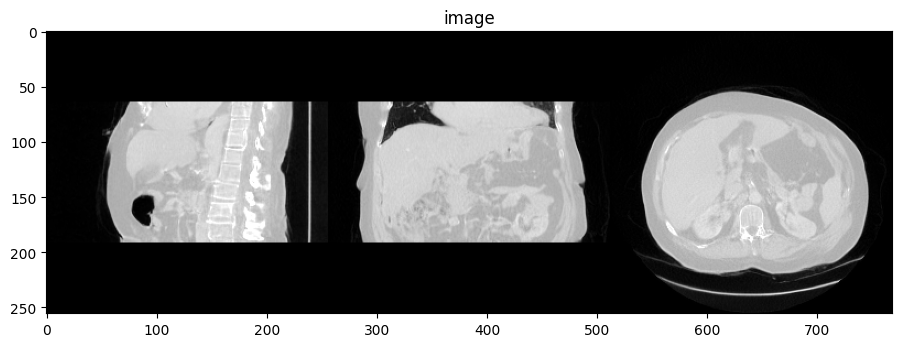

In [9]:
visualize_image_filename = saved_filepath[0]
logger.info(f"Visualizing {visualize_image_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))

# visualize for CT HU intensity between [-200, 500]
if generate_version == "rflow-mr":
    image_volume = torch.clip(image_volume, 0, 1000)
else:
    image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(image_volume[0,...], [-3, -2, -1]))
print(center_loc_axis)

# visualization
vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")